# Question 2: DH algorithm (50 points)
**In this question we are going to implement the DH algorithm according to the paper https://icml.cc/Conferences/2008/papers/324.pdf and try to predict protein localization sites in Eukaryotic cells.**

### Wald's Approximation

$$\hat{p}_{v,l} \pm z_{\alpha}\sqrt{\left( \frac{\hat{p}_{v,l}\left( 1-\hat{p}_{v,l} \right)}{n} \right)} $$

where 
- $z_{\alpha}$ is the $\left( 1-\frac{\alpha}{2}\right)$ percentile of the standard normal distribution $N(0,1)$

### Imports

In [1]:
import copy
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import choice
from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.model_selection import train_test_split



# provided custom modules
import packages.dh.helper as helper
import packages.dh.dh as dh

# setup
seed = 2021
warnings. filterwarnings("ignore")

## Part 2.0 Data loading and hierarchical clustering
**The DH algorithm is based on hierarchical clustering of the dataset. We will use the DH algorithm on this classification problem: [Protein Localization Prediction](https://archive.ics.uci.edu/ml/datasets/Yeast).**

**The first step is to load the dataset and conduct a hierarchical clustring using the `scipy` package. This part has been implemented, read through the code to make sure you understand what is being done.**

**NOTES:**
- **X_train: data matrix 1200x8**
- **Y_train: true labels 1200x1**
- **X_test: data matrix 284x8**
- **Y_test: true labels 284x1**

**TIPS:**
- **Check out this [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) for details about hierarchical clustering.**
- **If you are unfamiliar with hierarchical clustering using scipy, [this](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/ ) is another helpful resource. (We won't use dendrograms here, but he gives a nice explanation of how to interpret the linkage matrix).**
               

### Explore data

In [2]:
df =  pd.read_csv('data/data.csv')
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Label
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [3]:
np.unique(df.Label, return_counts=True)

(array(['MIT', 'NUC'], dtype=object), array([244, 429]))

### Load data

In [4]:
# read data
df = pd.read_csv('data/data.csv')

# filter out samples which are not in filter_class
filter_class = ['MIT', 'NUC']
mask = df.Label == 0
for x in filter_class:
    mask = mask | (df.Label == x)
df = df[mask]

# extract DataFrame features
X = df.iloc[:, :8].to_numpy()

# extract DataFrame labels and encode labels
y = df.Label.astype('category').cat.codes.to_numpy()

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(538, 8)
(538,)
(135, 8)
(135,)


### Construct hierarchy

In [5]:
# toy example
T = helper.generate_T(X_train[:4])
T

[array([[0, 3],
        [1, 2],
        [4, 5]]),
 array([1., 1., 1., 1., 2., 2., 4.]),
 {6: 0, 0: 4, 3: 4, 1: 5, 2: 5, 4: 6, 5: 6}]

# Part 2.0.1 Supervised classification methods.
**We provide several classifiers that can be used. Choose your favourite one. The classifier is going to be used in 2.2, the choose of classifier won't influence your grade.**

**TODO:**
- **Choose and initialize a classifier**

**Note: To use the Neural Network classifier, you need to install [pytorch](https://pytorch.org/).**

### Comparison of options

In [6]:
# # options
# lr = helper.get_classifier('Logistic Regression').fit(X_train,y_train)
# rf = helper.get_classifier('Random Forest', seed).fit(X_train,y_train)
# gbdt = helper.get_classifier('Gradient Boosting Decision Tree', seed).fit(X_train,y_train)
# nn = helper.get_classifier('Neural Net', X_train,y_train, seed).fit(X_train,y_train)


# # Accuracy of 4 classifiers.
# print('Accuracy of logistic regression: \t\t{:.3f}'.format(lr.score(X_test,y_test)))
# print('Accuracy of random forest: \t\t\t{:.3f}'.format(rf.score(X_test,y_test)))
# print('Accuracy of Gradient Boosting Decision Tree: \t{:.3f}'.format(gbdt.score(X_test,y_test)))
# print('Accuracy of Neural Network: \t\t\t{:.3f}'.format(nn.score(X_test,y_test)))

### Choose and initialize your classifier

In [7]:
classifier = helper.get_classifier('Logistic Regression')

## Part 2.1 Implement DH algorithm (Hierarchical Sampling for Active Learning). (30 points)

**TODO:**
- **Please complete the functions to implement the DH algorithm and run the active learning algorithm on the training dataset.**
- **The utils functions has been implemented and attached in the homework folder, including `update_empirical.py`, `best_pruning_and_labeling.py`, `assign_labels.py`, and `get_leaves.py`. Please read them and finish the following functions to implement the DH algorithm.**

In [8]:
# implemented in custom Python package dh

## Part 2.2 Run the sample code (10 points)
**TODO:**
- **Run the following sample code and compare the two figures.**

In [22]:
# ?? why make a copy of classifier when only one can be used in the function?
def call_DH(part, clf, budget, X_train, y_train, X_test, y_test):
    """
    Main function to run all your code once complete.  After you complete
   select_case_1() and select_case_2(), this will run the DH algorithm for each
   dataset and generate the plots you will submit within your write-up.

    :param part: which part of the homework to run
    :param clf: The classifier to be trained on the dataset.
    :param budget: The number of times that one can query a label from the oracle.
    :return:
    """
    num_trials = 5
    batch_size = 10
    clf2 = copy.deepcopy(clf)  # make a copy of the classifier so a comparison can be made
    axs = plt.subplot()

    # initialize components
    T = helper.generate_T(X_train)
    loss = np.zeros(budget)  # loss for each iteration
    
    # choose action depending on part
    if part.lower() == "b":

        print("Running part B...")

        # run trials
        for i in range(num_trials):
            print("Currently on iteration {}...".format(i))
            L, error = dh.select_case_1(X_train, y_train, T, budget, batch_size)
            loss += error
        loss /= num_trials


        # train the classifier clf on the predicted label.
        clf.fit(X_train, L[:len(X_train)])

        # plot
        score = clf.score(X_test, y_test)
        print('Accuracy of classifier trained on random sampling dataset: \t{:.3f}'.format(score))
        axs.plot(np.arange(budget), loss, label="Random sampling")

    elif part.lower() == "c":

        print("Running part C...")

        # run trials
        for i in range(num_trials):
            print("Currently on iteration {}...".format(i))
            L, error = dh.select_case_2(X_train, y_train, T, budget, batch_size)
            loss += error
        loss /= num_trials

        # train the classifier clf2 on the predicted label
        clf2.fit(X_train, L[:len(X_train)])

        score = clf2.score(X_test, y_test)
        print('Accuracy of classifier trained on active learning dataset: \t{:.3f}'.format(score))
        axs.plot(np.arange(budget), loss, label="Active learning")

    else:
        print("Incorrect part argument. Either 'b', 'c', 'd', or 'e' expected:", part)

#     axs.set_ylim([0, 0.5])
    axs.set_xlabel("Number of query samples")
    axs.set_ylabel("Error rate")
    plt.legend()
#     plt.savefig("img/q2_2" + part.lower() + ".png")
    print()
    

Running part B...
Currently on iteration 0...
Currently on iteration 1...
Currently on iteration 2...
Currently on iteration 3...
Currently on iteration 4...
Accuracy of classifier trained on random sampling dataset: 	0.600

Running part C...
Currently on iteration 0...
Currently on iteration 1...
Currently on iteration 2...
Currently on iteration 3...
Currently on iteration 4...
Accuracy of classifier trained on active learning dataset: 	0.578

CPU times: user 102 ms, sys: 8.21 ms, total: 110 ms
Wall time: 107 ms


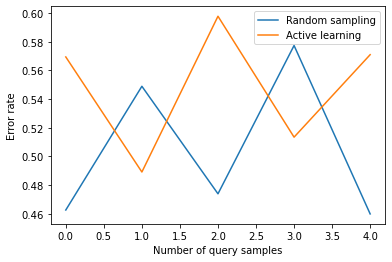

In [23]:
%%time

# run active learning
BUDGET = 5
for part in "bc":
    call_DH(part,classifier,BUDGET,X_train, y_train, X_test, y_test)


## Part 2.3 Questions (10 points):
**Answer the following questions.**
### What is a "admissible pair" according to the paper (5 points)?
### Please explain the sampling bias that is dealt with in the DH algorithm and why it would be a problem if we just query the unlabeled point which is closest to the decision boundary (5 points)?